# Slow-waves detection

This notebook demonstrates how to use YASA to automatically detect slow waves on single-channel EEG.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading

Let's load 30 seconds of N3 sleep on a single frontal EEG channel sampled at 100 Hz.

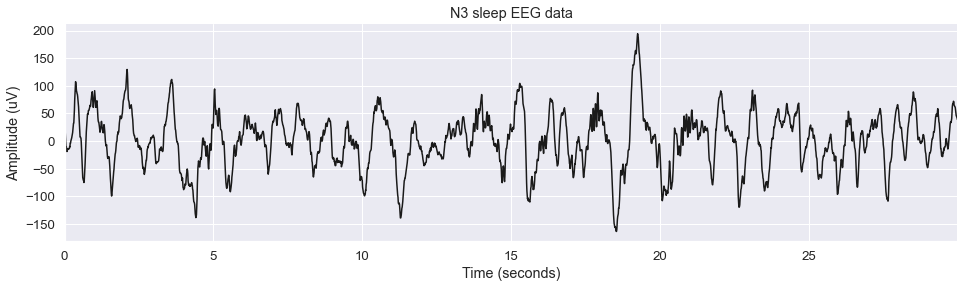

In [2]:
# Load data
data = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')

# Keep only Fz and during a N3 sleep period with (huge) slow-waves
data = data[1, 669000:672000].astype(np.float64)
hypno = hypno[669000:672000]

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

## Apply the detection using absolute thresholds (default)

We use the [yasa.sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.sw_detect.html#yasa.sw_detect) function to apply the detection. The different input and output parameters are described in the [documentation of the function](https://raphaelvallat.com/yasa/build/html/generated/yasa.sw_detect.html#yasa.sw_detect).

**Note**: as explained below, you can also use relative amplitude thresholds (e.g. z-score or percentiles) instead of absolute physical thresholds (in uV).

In [3]:
from yasa import sw_detect

# Short version
# sw = sw_detect(data, sf, hypno=hypno)

# Long version (with all the optional implicit arguments)
sw = sw_detect(data, sf, hypno=hypno, include=(2, 3), freq_sw=(0.3, 2),
               dur_neg=(0.3, 1.5), dur_pos=(0.1, 1), amp_neg=(40, 300), 
               amp_pos=(10, 150), amp_ptp=(75, 400), remove_outliers=False, 
               coupling=False, freq_sp=(12, 16))

# To get the full detection dataframe, we use the .summary() method
events = sw.summary()
events.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,1.20,1.62,1.81,2.03,2.41,1.21,-84.36,80.24,164.60,866.32,0.83,3,CHAN000,0
1,5.32,5.51,5.81,6.15,6.61,1.29,-69.84,34.50,104.34,347.81,0.78,3,CHAN000,0
2,8.15,8.41,8.63,8.81,8.97,0.82,-48.52,34.32,82.85,376.59,1.22,3,CHAN000,0
3,9.78,10.08,10.27,10.51,11.04,1.26,-69.07,92.89,161.96,852.43,0.79,3,CHAN000,0
4,11.04,11.30,11.57,11.74,11.93,0.89,-98.44,38.34,136.78,506.59,1.12,3,CHAN000,0
5,14.41,14.65,14.99,15.27,15.45,1.04,-55.45,101.43,156.88,461.41,0.96,3,CHAN000,0
6,15.45,15.65,16.08,16.29,16.92,1.47,-101.81,46.09,147.90,343.95,0.68,3,CHAN000,0
7,16.92,17.09,17.60,17.84,18.25,1.33,-40.93,59.75,100.68,197.41,0.75,3,CHAN000,0
8,18.25,18.54,18.93,19.77,19.86,1.61,-133.61,13.12,146.74,376.25,0.62,3,CHAN000,0
9,19.86,20.17,20.69,20.98,21.55,1.69,-100.74,33.37,134.11,257.91,0.59,3,CHAN000,0


The output of the slow-waves detection is a [SWResults](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults) class, which comes with some pre-compiled functions (also called methods). For instance, the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults.summary) method returns a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) with all the detected slow-waves and their properties. The different slow-waves properties are explained in the figure below:

<img src="https://raw.githubusercontent.com/raphaelvallat/yasa/master/docs/pictures/slow_waves.png" alt="slow-waves" style="width: 600px;"/>

Using the ``grp_chan`` argument of the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults.summary) method, we can also easily get the average parameters of all detected slow-waves:

In [4]:
sw.summary(grp_chan=True, aggfunc='mean')

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
CHAN000,16,1.108125,-76.69544,54.255959,130.951399,552.365534,0.995026


### Plot the detected slow-waves

First we need to create a boolean array of the same size of data indicating for each sample if this sample is part of a spindles or not. This is done using the [get_mask](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults.get_mask) method

In [5]:
# Let's get a mask indicating for each sample
mask = sw.get_mask()
mask

array([0, 0, 0, ..., 1, 1, 0])

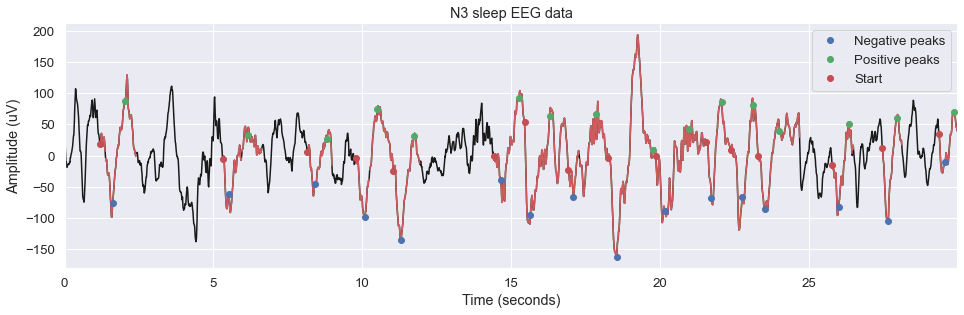

In [6]:
sw_highlight = data * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))

plt.plot(times, data, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()

You may notice that some of the peaks and start points looks a bit out of sync. This is because the slow-waves detection is calculated on a bandpass-filtered signal and not the raw signal. Let's do the same plot with the filtered signal:

In [7]:
# The 1D filtered data can be obtained using:
data_filt = np.squeeze(sw._data_filt)
data_filt

array([-7.10542736e-15, -5.68159687e+00, -1.12794579e+01, ...,
        6.55989903e+00,  3.30674687e+00, -1.77635684e-15])

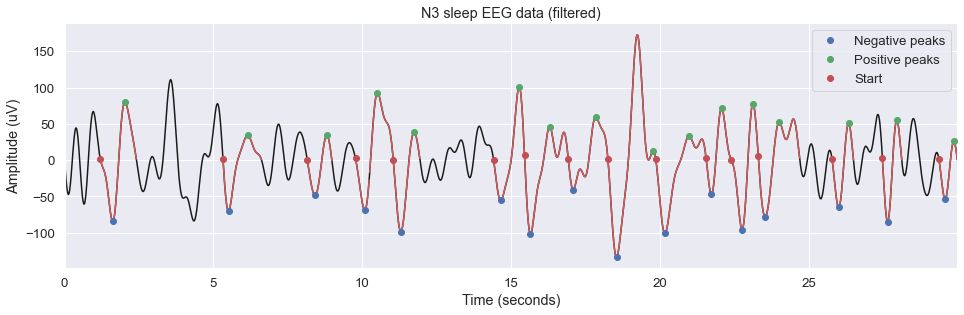

In [8]:
sw_highlight = data_filt * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))

plt.plot(times, data_filt, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], events['ValNegPeak'], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], events['ValPosPeak'], 'go', label='Positive peaks')
plt.plot(events['Start'], np.squeeze(sw._data_filt)[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data (filtered)')
plt.legend()
sns.despine()

Finally, we can plot an average template of all detected slow-waves with the [plot_average](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa.SWResults.plot_average) method:

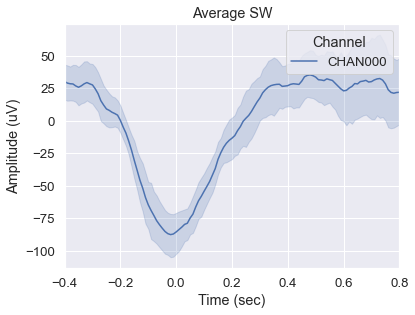

In [9]:
sw.plot_average(time_before=0.4, time_after=0.8, center="NegPeak");

### Computation time

In [10]:
%timeit sw_detect(data, sf)

13 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
# Line profiling
# %load_ext line_profiler
# %lprun -f sw_detect sw_detect(data, sf)

## Using relative thresholds

For a variety of reasons, one may prefer to use relative amplitude thresholds rather than absolute (physical) units. For instance, older adults typically have lower-amplitude slow-waves, for which the default thresholds defined by the AASM may not work properly (for more details, refer to [Muehlroth & Werkle-Bergner, 2020](https://doi.org/10.1111/psyp.13523)).

The script below demonstrates how to apply the detection on previously-normalized data. The amplitude thresholds are defined in terms of z-scores, i.e. the number of standard deviations from the mean.

In [12]:
from scipy.stats import zscore

# Z-score the data
data_zscored = zscore(data)

# Detect all events with a relative peak-to-peak 
# amplitude between 3 to 10 z-scores, and positive/negative
# peaks amplitude > 1 standard deviations
sw = sw_detect(data_zscored, sf, 
               amp_neg=(1, None), 
               amp_pos=(1, None), 
               amp_ptp=(3, 10))

sw.summary().round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,1.28,1.56,1.81,2.08,2.37,1.09,-1.59,1.64,3.23,12.94,0.92,CHAN000,0
1,9.77,10.03,10.26,10.59,11.01,1.24,-1.35,1.69,3.05,13.26,0.81,CHAN000,0
2,18.21,18.61,18.91,19.22,19.68,1.47,-2.48,3.02,5.51,18.36,0.68,CHAN000,0
3,22.42,22.71,22.94,23.13,23.32,0.90,-1.79,1.30,3.09,13.45,1.11,CHAN000,0


Even without z-scoring the data, one can directly use a percentile threshold on the raw data to determine the amplitude. In the code below, we show how to detect any peaks that exceed the 75th percentile of the raw data, e.g. from [Helfrich et al. 2018](https://www.ncbi.nlm.nih.gov/pubmed/29249289):

> *(1) Slow oscillations: In brief, we first filtered the continuous signal between 0.16 and1.25 Hz and detected all the zero crossings. Then events were selected based on time (0.8 – 2 s duration) and amplitude (75% percentile) criteria.*

Also note how we can disable the positive and negative amplitude thresholds by simply using "None"

In [13]:
thresh = np.percentile(np.abs(data), 75)

print('75th percentile threshold: %.2f uV' % thresh)

sw = sw_detect(data, sf, 
               amp_neg=(None, None), # Disabled
               amp_pos=(None, None), # Disabled
               amp_ptp=(thresh, np.inf)  # No upper threshold: np.inf
              )

sw.summary().round(2)

75th percentile threshold: 55.41 uV


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.34,0.62,0.80,1.07,1.28,0.94,-18.66,46.55,65.21,362.30,1.06,CHAN000,0
1,1.28,1.56,1.81,2.08,2.37,1.09,-79.37,81.73,161.10,644.41,0.92,CHAN000,0
2,2.37,3.10,3.24,3.58,3.84,1.47,-18.74,89.65,108.39,774.24,0.68,CHAN000,0
3,3.84,4.13,4.76,5.07,5.32,1.48,-79.42,64.50,143.92,228.45,0.68,CHAN000,0
4,5.32,5.56,5.82,6.05,6.57,1.25,-59.57,30.93,90.50,348.07,0.80,CHAN000,0
5,6.57,6.80,6.98,7.20,7.41,0.84,-29.53,39.45,68.98,383.22,1.19,CHAN000,0
6,8.14,8.37,8.62,8.80,8.98,0.84,-49.49,26.22,75.71,302.83,1.19,CHAN000,0
7,8.98,9.21,9.42,9.61,9.77,0.79,-38.15,34.74,72.89,347.09,1.27,CHAN000,0
8,9.77,10.03,10.26,10.59,11.01,1.24,-67.49,84.36,151.85,660.20,0.81,CHAN000,0
9,11.01,11.30,11.58,11.75,11.95,0.94,-88.81,37.14,125.95,449.82,1.06,CHAN000,0


**************************

## Step-by-step description of the algorithm

The slow-waves detection algorithm of YASA is a custom adaptation from:

- Massimini, M., Huber, R., Ferrarelli, F., Hill, S. & Tononi, G. (2004). [The sleep slow oscillation as a traveling wave](https://doi.org/10.1523/JNEUROSCI.1318-04.2004). *J. Neurosci.*. 

- Carrier, J. et al. (2011). [Sleep slow wave changes during the middle years of life](https://doi.org/10.1111/j.1460-9568.2010.07543.x). *Eur. J. Neurosci*.

**The steps are:**
1. Bandpass filtering between 0.3 to 2 Hz using a [FIR filter](https://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html#designing-fir-filters) with a transition band of 0.2 Hz.
2. Detection of all the negative peaks in the filtered signal that have an amplitude between -40 to -300 $\mu$V and all the positive peaks with an amplitude comprised between 10 to 200 $\mu$V. This is done using the [scipy.signal.find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function.
3. For each negative peak (= slow-wave trough), the nearest following positive peak is found and several metrics are computed, such as the peak-to-peak amplitude, durations of the negative and positive phase, frequency, etc.
4. A set of logical thresholds are applied to determine the *true* slow-waves.
5. A pandas DataFrame is created, where each row is a detected slow-wave and each column a property of this slow-wave. An optional automatic outlier rejection is applied on this dataframe to further remove abnormal slow-waves.

### 1. Bandpass filtering

Setting up band-pass filter from 0.3 - 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 2.10 Hz)
- Filter length: 1651 samples (16.510 sec)

Using filter length: 1651
Smart-padding with:  1650 samples on each edge
FFT block length:   8192


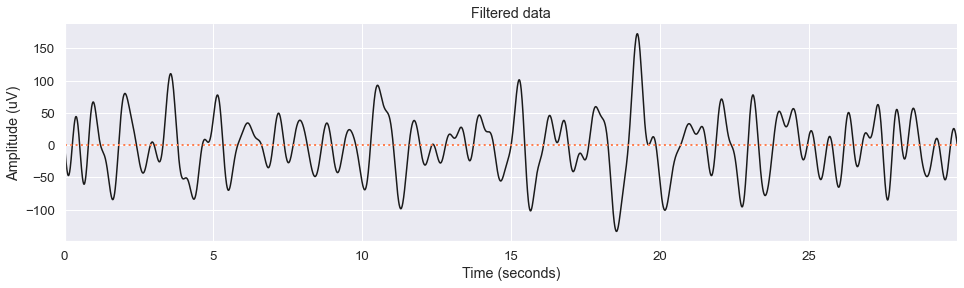

In [14]:
# Slow-waves FIR bandpass filter
freq_sw = (0.3, 2)
data_filt = filter_data(data, sf, freq_sw[0], freq_sw[1], method='fir', verbose=1, 
                        l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.axhline(0, color='coral', ls=':', lw=2)
plt.title('Filtered data')
sns.despine()

### 2. Peaks detection

In [15]:
from scipy.signal import find_peaks

# Negative peaks with value comprised between -40 to -300 uV
idx_neg_peaks, _ = find_peaks(-1 * data_filt, height=(40, 300))

# Positive peaks with values comprised between 10 to 150 uV
idx_pos_peaks, _ = find_peaks(data_filt, height=(10, 150))

display(idx_neg_peaks)
display(idx_pos_peaks)

array([  13,   65,  162,  264,  399,  434,  551,  841,  917, 1008, 1130,
       1465, 1565, 1709, 1854, 2017, 2173, 2276, 2353, 2540, 2600, 2765,
       2897, 2958])

array([  39,   96,  203,  356,  514,  615,  719,  790,  881,  957, 1051,
       1174, 1294, 1332, 1393, 1424, 1527, 1629, 1677, 1784, 1977, 2098,
       2141, 2207, 2312, 2401, 2448, 2508, 2570, 2634, 2691, 2732, 2795,
       2851, 2930, 2987])

In [16]:
# For each negative peak, we find the closest following positive peak
pk_sorted = np.searchsorted(idx_pos_peaks, idx_neg_peaks)
closest_pos_peaks = idx_pos_peaks[pk_sorted] - idx_neg_peaks
closest_pos_peaks = closest_pos_peaks[np.nonzero(closest_pos_peaks)]

idx_pos_peaks = idx_neg_peaks + closest_pos_peaks
idx_pos_peaks

array([  39,   96,  203,  356,  514,  514,  615,  881,  957, 1051, 1174,
       1527, 1629, 1784, 1977, 2098, 2207, 2312, 2401, 2570, 2634, 2795,
       2930, 2987])

### 3. Amplitude and duration criteria

In [17]:
# Now we check that the total PTP amplitude is within our bounds (75 to 400 uV)
sw_ptp = np.abs(data_filt[idx_neg_peaks]) + data_filt[idx_pos_peaks]
good_ptp = np.logical_and(sw_ptp > 75, sw_ptp < 400)
display(np.round(sw_ptp))
display(good_ptp)

array([ 91., 128., 165., 154., 130., 161., 104.,  83.,  67., 162., 137.,
       157., 148., 101., 147., 134., 119., 174., 131.,  67., 116., 140.,
        59.,  79.])

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True])

In [18]:
# Remove the slow-waves with peak-to-peak ampitude outside the bounds
sw_ptp = sw_ptp[good_ptp]
idx_neg_peaks = idx_neg_peaks[good_ptp]
idx_pos_peaks = idx_pos_peaks[good_ptp]
idx_neg_peaks

array([  13,   65,  162,  264,  399,  434,  551,  841, 1008, 1130, 1465,
       1565, 1709, 1854, 2017, 2173, 2276, 2353, 2600, 2765, 2958])

In [19]:
# Then we check the negative and positive phase duration. To do so,
# we first need to compute the zero crossings of the filtered signal:
zero_crossings = yasa.others._zerocrossings(data_filt)
zero_crossings

array([  26,   50,   79,  120,  181,  241,  287,  301,  330,  379,  462,
        532,  581,  661,  700,  738,  767,  815,  863,  897,  938,  978,
       1027, 1104, 1157, 1193, 1233, 1240, 1279, 1347, 1373, 1441, 1499,
       1545, 1608, 1692, 1760, 1825, 1893, 1986, 2069, 2155, 2187, 2239,
       2295, 2330, 2379, 2469, 2494, 2519, 2561, 2578, 2618, 2650, 2678,
       2747, 2781, 2812, 2831, 2872, 2921, 2937, 2975, 2998])

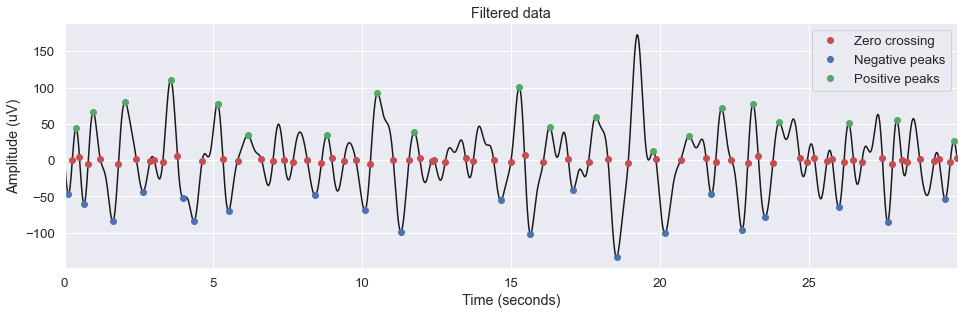

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4.5))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.plot(times[zero_crossings], data_filt[zero_crossings], 'ro', label='Zero crossing')
plt.plot(times[idx_neg_peaks], data_filt[idx_neg_peaks], 'bo', label='Negative peaks')
plt.plot(times[idx_pos_peaks], data_filt[idx_pos_peaks], 'go', label='Positive peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('Filtered data')
plt.legend()
sns.despine()

In [21]:
# Safety check: Make sure that there is a zero-crossing after the last detected peak
if zero_crossings[-1] < max(idx_pos_peaks[-1], idx_neg_peaks[-1]):
    # If not, append the index of the last peak
    zero_crossings = np.append(zero_crossings,
                               max(idx_pos_peaks[-1], idx_neg_peaks[-1]))

In [22]:
# For each negative peak, we find the previous and following zero-crossings
neg_sorted = np.searchsorted(zero_crossings, idx_neg_peaks)
previous_neg_zc = zero_crossings[neg_sorted - 1] - idx_neg_peaks
following_neg_zc = zero_crossings[neg_sorted] - idx_neg_peaks

# And from that we calculate the duration of the negative phase
neg_phase_dur = (np.abs(previous_neg_zc) + following_neg_zc) / sf
neg_phase_dur

array([29.98,  0.29,  0.61,  0.46,  0.83,  0.83,  0.49,  0.48,  0.49,
        0.53,  0.58,  0.63,  0.68,  0.68,  0.83,  0.32,  0.56,  0.49,
        0.4 ,  0.34,  0.38])

In [23]:
# For each positive peak, we find the previous and following zero-crossings
pos_sorted = np.searchsorted(zero_crossings, idx_pos_peaks)
previous_pos_zc = zero_crossings[pos_sorted - 1] - idx_pos_peaks
following_pos_zc = zero_crossings[pos_sorted] - idx_pos_peaks

# And from that we calculate the duration of the positive phase
pos_phase_dur = (np.abs(previous_pos_zc) + following_pos_zc) / sf
pos_phase_dur

array([0.24, 0.41, 0.6 , 0.49, 0.7 , 0.7 , 0.8 , 0.34, 0.77, 0.36, 0.46,
       0.84, 0.65, 0.93, 0.86, 0.52, 0.35, 0.9 , 0.32, 0.31, 0.23])

In [24]:
# Now we can start computing the properties of each detected slow-waves
sw_start = times[idx_neg_peaks + previous_neg_zc]
sw_end = times[idx_pos_peaks + following_pos_zc]
sw_dur = sw_end - sw_start  # Same as pos_phase_dur + neg_phase_dur
sw_midcrossing = times[idx_neg_peaks + following_neg_zc]
sw_idx_neg, sw_idx_pos = times[idx_neg_peaks], times[idx_pos_peaks]
sw_slope = sw_ptp / (sw_midcrossing - sw_idx_neg)  # Slope between peak trough and midcrossing

In [25]:
# Finally we apply a set of logical thresholds to exclude "bad" slow waves
good_sw = np.logical_and.reduce((
                                # Data edges
                                previous_neg_zc != 0,
                                following_neg_zc != 0,
                                previous_pos_zc != 0,
                                following_pos_zc != 0,
                                # Duration criteria
                                neg_phase_dur > 0.3,
                                neg_phase_dur < 1.5,
                                pos_phase_dur > 0.1,
                                pos_phase_dur < 1,
                                # Sanity checks
                                sw_midcrossing > sw_start,
                                sw_midcrossing < sw_end,
                                sw_slope > 0,
                                ))

good_sw

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### 4. Dataframe creation

In [26]:
# Create the dataframe
events = pd.DataFrame({'Start': sw_start,
                       'NegPeak': sw_idx_neg,
                       'MidCrossing': sw_midcrossing,
                       'PosPeak': sw_idx_pos,  
                       'End': sw_end, 
                       'Duration': sw_dur,
                       'ValNegPeak': data_filt[idx_neg_peaks], 
                       'ValPosPeak': data_filt[idx_pos_peaks], 
                       'PTP': sw_ptp, 
                       'Slope': sw_slope, 
                       'Frequency': 1 / sw_dur,
                        })[good_sw]

# Remove all duplicates and reset index
events.drop_duplicates(subset=['Start'], inplace=True, keep=False)
events.drop_duplicates(subset=['End'], inplace=True, keep=False)
events.reset_index(drop=True, inplace=True)
events.round(3)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
0,1.20,1.62,1.81,2.03,2.41,1.21,-84.356,80.244,164.600,866.316,0.826
1,2.41,2.64,2.87,3.56,3.79,1.38,-43.128,110.881,154.009,669.603,0.725
2,5.32,5.51,5.81,6.15,6.61,1.29,-69.838,34.503,104.342,347.806,0.775
3,8.15,8.41,8.63,8.81,8.97,0.82,-48.525,34.325,82.849,376.588,1.220
4,9.78,10.08,10.27,10.51,11.04,1.26,-69.073,92.889,161.962,852.432,0.794
5,11.04,11.30,11.57,11.74,11.93,0.89,-98.443,38.336,136.779,506.588,1.124
6,14.41,14.65,14.99,15.27,15.45,1.04,-55.451,101.429,156.879,461.410,0.962
7,15.45,15.65,16.08,16.29,16.92,1.47,-101.812,46.087,147.900,343.953,0.680
8,16.92,17.09,17.60,17.84,18.25,1.33,-40.932,59.747,100.680,197.411,0.752
9,18.25,18.54,18.93,19.77,19.86,1.61,-133.613,13.124,146.737,376.248,0.621


**********************

## Appendix

### 1. Display the time points in HH:MM:SS format

In [27]:
for c in ['Start', 'NegPeak', 'MidCrossing', 'PosPeak', 'End']:
    events[c] = pd.to_timedelta(events[c], unit='s').dt.round('s')

events.head()

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
0,0 days 00:00:01,0 days 00:00:02,0 days 00:00:02,0 days 00:00:02,0 days 00:00:02,1.21,-84.356423,80.243566,164.599990,866.315734,0.826446
1,0 days 00:00:02,0 days 00:00:03,0 days 00:00:03,0 days 00:00:04,0 days 00:00:04,1.38,-43.127910,110.880737,154.008647,669.602811,0.724638
2,0 days 00:00:05,0 days 00:00:06,0 days 00:00:06,0 days 00:00:06,0 days 00:00:07,1.29,-69.838461,34.503461,104.341922,347.806407,0.775194
3,0 days 00:00:08,0 days 00:00:08,0 days 00:00:09,0 days 00:00:09,0 days 00:00:09,0.82,-48.524604,34.324745,82.849349,376.587950,1.219512
4,0 days 00:00:10,0 days 00:00:10,0 days 00:00:10,0 days 00:00:11,0 days 00:00:11,1.26,-69.073328,92.888671,161.961999,852.431571,0.793651


### 2. Get additional information with logging

YASA uses the [logging](https://docs.python.org/3/library/logging.html) module to selectively print relevant messages. The default level of the logger is set to "WARNING", which means that a message will only be displayed if a warning occurs. However, you can easily set this parameter to "INFO" to get some relevant infos about the detection pipeline and the data.

This can be useful to debug the detection and/or if you feel that the detection is not working well on your data.

In [28]:
yasa.sw_detect(data, sf, verbose='INFO').summary().head()

22-Jun-21 16:43:58 | INFO | Number of samples in data = 3000
22-Jun-21 16:43:58 | INFO | Sampling frequency = 100.00 Hz
22-Jun-21 16:43:58 | INFO | Data duration = 30.00 seconds
22-Jun-21 16:43:58 | INFO | Trimmed standard deviation of CHAN000 = 37.9487 uV
22-Jun-21 16:43:58 | INFO | Peak-to-peak amplitude of CHAN000 = 357.7428 uV


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,1.28,1.56,1.81,2.08,2.37,1.09,-79.368650,81.733843,161.102493,644.409972,0.917431,CHAN000,0
1,3.84,4.13,4.76,5.07,5.32,1.48,-79.424450,64.495936,143.920386,228.445057,0.675676,CHAN000,0
2,5.32,5.56,5.82,6.05,6.57,1.25,-59.569601,30.927658,90.497258,348.066378,0.800000,CHAN000,0
3,8.14,8.37,8.62,8.80,8.98,0.84,-49.491289,26.215151,75.706440,302.825759,1.190476,CHAN000,0
4,9.77,10.03,10.26,10.59,11.01,1.24,-67.486154,84.359223,151.845376,660.197288,0.806452,CHAN000,0


### 3. Compute the pointwise relative delta power

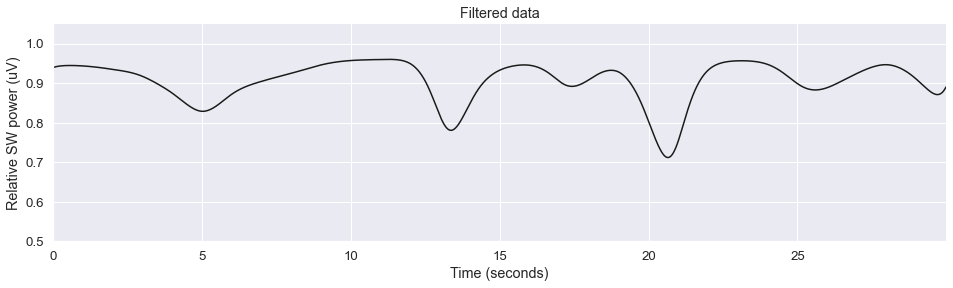

In [29]:
from scipy.interpolate import interp1d

# Compute the pointwise relative delta power using interpolated STFT
# Here we use a window of 5 seconds with a step of 1 sec.
f, t, Sxx = yasa.spectral.stft_power(data, sf, window=5, step=1, interp=True, norm=True)
idx_sw = np.logical_and(f >= 0.5, f <= 3.5)
sw_rel_pow = Sxx[idx_sw].sum(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, sw_rel_pow, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Relative SW power (uV)')
plt.xlim([times.min(), times.max()])
plt.ylim(0.5, 1.05)
plt.title('Filtered data')
sns.despine()